### 3x3 Simple Maze

In [9]:
import numpy as np

In [10]:
x = np.array([[1, 1, 1, 1, 1],
              [1, 0, 0, 0, 1],
              [1, 0, 0, 0, 1],
              [1, 0, 0, 0, 1],
              [1, 1, 1, 1, 1]])
robber_start_idx = [[1, 1]]
police_start_idx = [[2, 3]]
goal_idx = [[3, 3]]
env_id = 'Simple3x3Maze-v0'

### Make Environment

In [4]:
from mazelab import BaseMaze
from mazelab import Object
from mazelab import DeepMindColor as color

class Maze(BaseMaze):
    @property
    def size(self):
        return x.shape
    
    def make_objects(self):
        free = Object('free', 0, color.free, False, np.stack(np.where(x == 0), axis=1))
        obstacle = Object('obstacle', 1, color.obstacle, True, np.stack(np.where(x == 1), axis=1))
        # no locations specified for agent and goal
        robber = Object('robber', 2, color.agent_robber, False, [])
        police = Object('police', 3, color.agent_police, False, [])
        goal = Object('goal', 4, color.goal, False, [])
        return free, obstacle, robber, police, goal

In [5]:
from mazelab import BaseEnv
from mazelab import VonNeumannMotion

import gym
from gym.spaces import Box
from gym.spaces import Discrete


class Env(BaseEnv):
    def __init__(self):
        super().__init__()
        
        self.maze = Maze()
        self.motions = VonNeumannMotion()
        
        self.observation_space = Box(low=0, high=len(self.maze.objects), shape=self.maze.size, dtype=np.uint8)
        self.action_space = Discrete(len(self.motions))
        
    def step(self, action):
        motion = self.motions[action]
        current_position = self.maze.objects.agent.positions[0]
        new_position = [current_position[0] + motion[0], current_position[1] + motion[1]]
        valid = self._is_valid(new_position)
        if valid:
            self.maze.objects.agent.positions = [new_position]
        
        if self._is_goal(new_position):
            reward = +1
            done = True
        elif not valid:
            reward = -1
            done = False
        else:
            reward = -0.01
            done = False
        return self.maze.to_value(), reward, done, {}
        
    def reset(self):
        self.maze.objects.robber.positions = robber_start_idx
        self.maze.objects.police.positions = police_start_idx
        self.maze.objects.goal.positions = goal_idx
        return self.maze.to_value()
    
    def _is_valid(self, position):
        nonnegative = position[0] >= 0 and position[1] >= 0
        within_edge = position[0] < self.maze.size[0] and position[1] < self.maze.size[1]
        passable = not self.maze.to_impassable()[position[0]][position[1]]
        return nonnegative and within_edge and passable
    
    def _is_goal(self, position):
        out = False
        for pos in self.maze.objects.goal.positions:
            if position[0] == pos[0] and position[1] == pos[1]:
                out = True
                break
        return out
    
    def get_image(self):
        return self.maze.to_rgb()

In [6]:
gym.envs.register(id=env_id, entry_point=Env, max_episode_steps=200)

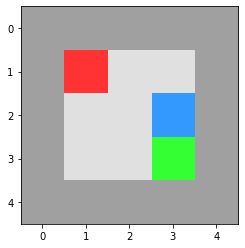

In [12]:
import matplotlib.pyplot as plt

env = gym.make(env_id)
obs = env.reset()
img = env.get_image()
plt.imshow(img, interpolation='nearest')

In [13]:
print(obs)

[[1 1 1 1 1]
 [1 2 0 0 1]
 [1 0 0 3 1]
 [1 0 0 4 1]
 [1 1 1 1 1]]
